In [3]:
import pandas as pd
import numpy as np

### buy and hold
1. 결측치 및 이상치를 조회 및 삭제
2. 종가를 기준으로 수익율 측정 
3. 일별 수익율 파생변수 
4. CAGR, MDD, VOL, sharpe를 출력

In [15]:
## 데이터 로드 
df = pd.read_csv("../csv/AAPL.csv", index_col='Date')
df.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.410525,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.389106,43971200.0


In [16]:
## 결측치 및 이상치를 조회
## any를 하면 인덱스 당 true  False 가 나오지만
## any 가 없으면 전체 데이터프레임에 각 셀별로 True Flase 가 나옴
# any(0) 은 컬럼을 기준 any(1)은 행기준 
df[df.isin([np.nan, np.inf, -np.inf]).any(1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1981-08-10,NaN,NaN,NaN,NaN,NaN,NaN
1981-08-21,0.363839,0.363839,0.359375,0.359375,0.287367,NaN


In [17]:
## 결측치 및 이상치를 제외한 데이터를 출력
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [18]:
## 종가만 사용 (Adj Close) 

#case1
# df[["Adj Close"]]

#case2
price_df = df.loc[:, ["Adj Close"]]

<AxesSubplot:xlabel='Date'>

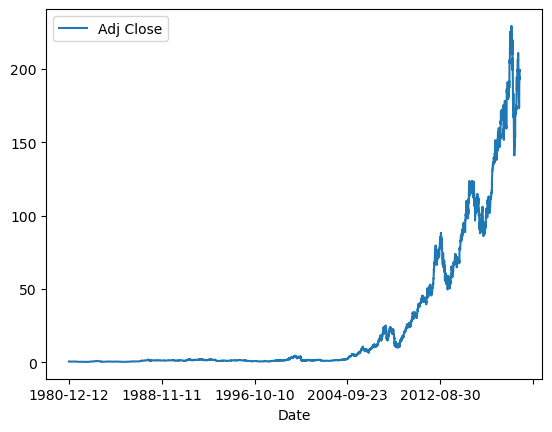

In [19]:
price_df.plot()

In [20]:
## 일별 수익율 생성
## (오늘 날짜의 종가 - 어제 날짜의 종가) / 어제 날짜의 종가
# daily_rtn 파생변수로 생성

# case1 diff(), shift()
price_df['Adj Close'].diff() / price_df['Adj Close'].shift()

# case2 shift()
(price_df['Adj Close'] - price_df["Adj Close"].shift()) / price_df['Adj Close'].shift()

# case3 pct_change()
price_df['daily_rtn'] = price_df['Adj Close'].pct_change()

In [21]:
price_df.head(10)

,Adj Close,daily_rtn
Date,,
1980-12-12,0.410525,NaN
1980-12-15,0.389106,-0.052175
1980-12-16,0.360548,-0.073394
1980-12-17,0.369472,0.024751
1980-12-18,0.380182,0.028987
1980-12-19,0.403385,0.061031
1980-12-22,0.423019,0.048673
1980-12-23,0.440868,0.042194
1980-12-24,0.464072,0.052633


In [22]:
## 일별 수익율 가지고 총 수익율을 구하려면?
## 누적곱 cumprod()
## st_rtn 파생변수 생성
price_df['st_rtn'] = (1 + price_df['daily_rtn']).cumprod()

In [23]:
price_df.head(10)

,Adj Close,daily_rtn,st_rtn
Date,,,
1980-12-12,0.410525,NaN,NaN
1980-12-15,0.389106,-0.052175,0.947825
1980-12-16,0.360548,-0.073394,0.878261
1980-12-17,0.369472,0.024751,0.899999
1980-12-18,0.380182,0.028987,0.926087
1980-12-19,0.403385,0.061031,0.982608
1980-12-22,0.423019,0.048673,1.030434
1980-12-23,0.440868,0.042194,1.073913
1980-12-24,0.464072,0.052633,1.130435


<AxesSubplot:xlabel='Date'>

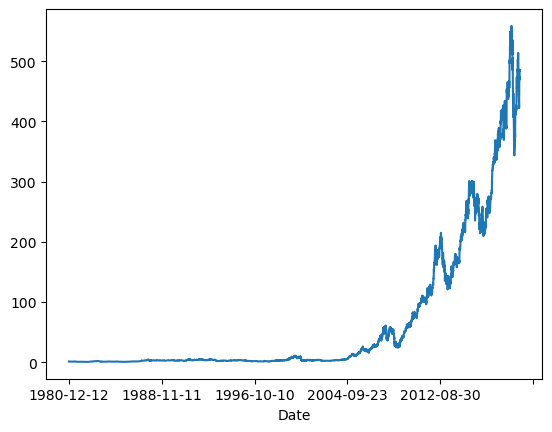

In [24]:
price_df['st_rtn'].plot()

In [25]:
## 종가를 기준으로 수익율 계산
# 마지막 데이터의 종가 / 처음 데이터의 종가
# 데이터프레임.index --> list 형태의 데이터가 출력
# list형태의 데이터에서 첫번째 원소가 구매일, list 마지막 원소가 판매일
# 데이터프레임 필터링 판매일에 종가 / 구매일의 종가 --> 수익율 
price_df.index
first_date = price_df.index[0]
last_date = price_df.index[-1]

## 구매일에 종가 출력
price_df.loc[last_date, 'Adj Close'] / price_df.loc[first_date, 'Adj Close']


485.15924243346933

In [26]:

## 누적 수익율 출력
price_df.loc[last_date, 'st_rtn']

485.1592424334637

In [27]:
a = [1,2,3,4,5]
## 변수명[index] --> index 위치의 데이터가 출력
# list 데이터에서 첫번째 값 출력
print(a[0])
# list 데이터에서 마지막 값 출력
print(a[-1])

1
5


<AxesSubplot:xlabel='Date'>

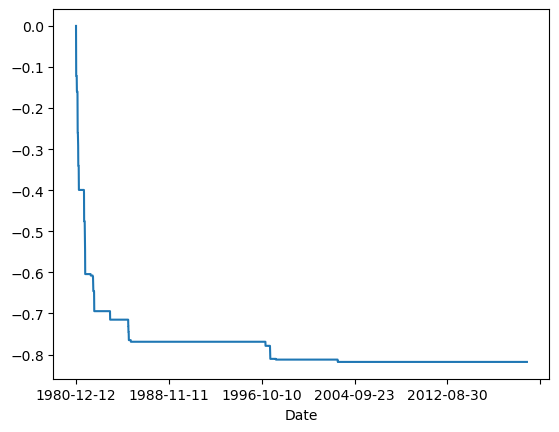

In [34]:
# backtesting 

# cummax() - 기준 값에서 최고가 저장
# cummin() - 기준 값에서 최저가 저장

historical_max = price_df['Adj Close'].cummax()
daily_drawdown = price_df["Adj Close"] / historical_max - 1.0
## 최대 낙폭 
historical_min =  daily_drawdown.cummin()
historical_min.plot()

In [35]:
## CAGR, MDD, VOL, sharpe 출력
## CAGR : 일별 date 사용 -> 
# 전체 연도를 계산하는 경우 영업일 기간을 252일 기준으로 나눈 역수 제곱한 후 -1
## MDD : 최대 낙폭
## VOL : 연 주가 수익율 표준편차 = 일별 주가 수익율 * 252일 제곱근
## sharpe : 총 위험 1단위당 초과 수익율
CAGR = price_df.loc[last_date, 'st_rtn'] ** (252/len(price_df)) - 1
MDD = historical_min.min()
VOL = np.std(price_df["daily_rtn"] * np.sqrt(252))
sharpe = np.mean(price_df["daily_rtn"]) / np.std(price_df["daily_rtn"])*np.sqrt(252)

In [32]:
print('CAGR : ', round(CAGR*100, 2), '%')
print('Sharpe : ', round(sharpe, 2))
print('VOL : ', round(VOL*100, 2), '%')
print('MDD : ', round(-1*MDD*100, 2), '%')

CAGR :  17.4 %
Sharpe :  0.58
VOL :  45.7 %
MDD :  81.8 %


In [33]:
VOL

0.4570483127920231

In [1]:
import buy_and_hold as bah
import imp
imp.reload(bah)

C:\Users\msi\AppData\Local\Temp\ipykernel_1492\1364790374.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<module 'buy_and_hold' from 'c:\\ubion\\221220\\buy_and_hold\\__init__.py'>

In [4]:
## 데이터프레임 로드 
df_2 = pd.read_csv("../csv/AMZN.csv", index_col='Date')

In [6]:
## 클래스 생성
bh = bah.BuyAndHold(df_2, 'Adj Close')

In [7]:
bh.drop_na()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...
2019-06-18,1901.349976,1921.670044,1899.790039,1901.369995,1901.369995,3895700
2019-06-19,1907.839966,1919.579956,1892.469971,1908.790039,1908.790039,2895300
2019-06-20,1933.329956,1935.199951,1905.800049,1918.189941,1918.189941,3217200


In [8]:
bh.add_col()

,Open,High,Low,Close,Adj Close,Volume,daily_rtn,st_rtn
Date,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,-0.117021,0.882979
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,-0.012049,0.872340
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,-0.042683,0.835107
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,-0.127389,0.728723
...,...,...,...,...,...,...,...,...
2019-06-18,1901.349976,1921.670044,1899.790039,1901.369995,1901.369995,3895700,0.008133,970.912503
2019-06-19,1907.839966,1919.579956,1892.469971,1908.790039,1908.790039,2895300,0.003902,974.701462
2019-06-20,1933.329956,1935.199951,1905.800049,1918.189941,1918.189941,3217200,0.004925,979.501413


In [9]:
bh.testing()

[0.365793900198663, 0.8136327617304022, 0.600898471235561, -0.944042179261863]

In [10]:
print('CAGR : ', round(CAGR*100, 2), '%')
print('Sharpe : ', round(sharpe, 2))
print('VOL : ', round(VOL*100, 2), '%')
print('MDD : ', round(-1*MDD*100, 2), '%')

NameError: name 'CAGR' is not defined

In [16]:
import yfinance as yf

In [17]:
df_3 = yf.download('003490.KS', start='2018-01-01')
df_3.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1224 entries, 2018-01-02 to 2022-12-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1224 non-null   float64
 1   High       1224 non-null   float64
 2   Low        1224 non-null   float64
 3   Close      1224 non-null   float64
 4   Adj Close  1224 non-null   float64
 5   Volume     1224 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 66.9 KB


In [18]:
df_3

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,34100.0,36100.0,34100.0,35900.0,35715.164062,1360084
2018-01-03,35950.0,36150.0,35550.0,35750.0,35565.937500,497403
2018-01-04,35500.0,35950.0,34900.0,34900.0,34720.312500,571308
2018-01-05,35250.0,35250.0,34450.0,34900.0,34720.312500,489822
2018-01-08,35100.0,36150.0,35100.0,36100.0,35914.136719,841491
...,...,...,...,...,...,...
2022-12-15,25300.0,25500.0,24800.0,24850.0,24850.000000,1143521
2022-12-16,24500.0,24750.0,24200.0,24700.0,24700.000000,1245099
2022-12-19,24700.0,24950.0,24450.0,24600.0,24600.000000,739463


In [19]:
bh_2 = bah.BuyAndHold(df_3, 'Close')

In [20]:
bh_2.drop_na()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,34100.0,36100.0,34100.0,35900.0,35715.164062,1360084
2018-01-03,35950.0,36150.0,35550.0,35750.0,35565.937500,497403
2018-01-04,35500.0,35950.0,34900.0,34900.0,34720.312500,571308
2018-01-05,35250.0,35250.0,34450.0,34900.0,34720.312500,489822
2018-01-08,35100.0,36150.0,35100.0,36100.0,35914.136719,841491
...,...,...,...,...,...,...
2022-12-15,25300.0,25500.0,24800.0,24850.0,24850.000000,1143521
2022-12-16,24500.0,24750.0,24200.0,24700.0,24700.000000,1245099
2022-12-19,24700.0,24950.0,24450.0,24600.0,24600.000000,739463


In [23]:
bh_2.add_col()

,Open,High,Low,Close,Adj Close,Volume,daily_rtn,st_rtn
Date,,,,,,,,
2018-01-02,34100.0,36100.0,34100.0,35900.0,35715.164062,1360084,NaN,NaN
2018-01-03,35950.0,36150.0,35550.0,35750.0,35565.937500,497403,-0.004178,0.995822
2018-01-04,35500.0,35950.0,34900.0,34900.0,34720.312500,571308,-0.023776,0.972145
2018-01-05,35250.0,35250.0,34450.0,34900.0,34720.312500,489822,0.000000,0.972145
2018-01-08,35100.0,36150.0,35100.0,36100.0,35914.136719,841491,0.034384,1.005571
...,...,...,...,...,...,...,...,...
2022-12-15,25300.0,25500.0,24800.0,24850.0,24850.000000,1143521,-0.015842,0.692201
2022-12-16,24500.0,24750.0,24200.0,24700.0,24700.000000,1245099,-0.006036,0.688022
2022-12-19,24700.0,24950.0,24450.0,24600.0,24600.000000,739463,-0.004049,0.685237


In [24]:
bh_2.testing()

[-0.0752580302659489,
 0.031666779892722104,
 0.4176052583016095,
 -0.760603518158236]

In [25]:
bh_2.df

,Open,High,Low,Close,Adj Close,Volume,daily_rtn,st_rtn
Date,,,,,,,,
2018-01-02,34100.0,36100.0,34100.0,35900.0,35715.164062,1360084,NaN,NaN
2018-01-03,35950.0,36150.0,35550.0,35750.0,35565.937500,497403,-0.004178,0.995822
2018-01-04,35500.0,35950.0,34900.0,34900.0,34720.312500,571308,-0.023776,0.972145
2018-01-05,35250.0,35250.0,34450.0,34900.0,34720.312500,489822,0.000000,0.972145
2018-01-08,35100.0,36150.0,35100.0,36100.0,35914.136719,841491,0.034384,1.005571
...,...,...,...,...,...,...,...,...
2022-12-15,25300.0,25500.0,24800.0,24850.0,24850.000000,1143521,-0.015842,0.692201
2022-12-16,24500.0,24750.0,24200.0,24700.0,24700.000000,1245099,-0.006036,0.688022
2022-12-19,24700.0,24950.0,24450.0,24600.0,24600.000000,739463,-0.004049,0.685237
